## Strategies Based on Simple Moving Averages (SMA)

*[Coding along with Python for Algorithmic Trading, Yves Hilpisch, O'Reilly, 1st edition November 2020, ISBN-13: 978-1492053354]*

__Moving averages__ according to *Claude.ai*:

> A moving average is a technical analysis tool that smooths out price data by creating a constantly updated average price over a specific time period, helping traders identify trends and potential support/resistance levels while filtering out short-term market noise.

Explaining the term term __"technical analysis"__, from a [paper on simple moving averages](https://finance.martinsewell.com/stylized-facts/distribution/BrockLakonishokLeBaron1992.pdf) by Brock at al. (1992):

> The term "technical analysis" is a general heading for a myriad of trading techniques. Technical analysts attempt to forecast prices by the study of past prices and a few other related summary statistics about security trading. They belief that shifts in supply and demand can be detected in charts of market action. Technical analysis is considered by many to be the original form of investment analysis, dating back to 1800s. It came into widespread use before the period of extensive and fully disclosed financial information, which in turn enabled the practice of fundamental analysis to develop.

More from this paper about technical rules:

> In this paper, we explore two of the simplest and most popular technical rules: moving average-oscillator and trading-range break (resistance and support levels). In the first method, buy and sell signals are generated by two moving averages, a long period and a short period. [...] Our study reveals that technical analysis reveals that technical analysis helps to predict stock changes.

### Basics of backtesting trading strategies that make use of two SMAs

In [1]:
# let's get pandas
import pandas as pd
import numpy as np
# and what we need from matplotlib
from pylab import mpl, plt

Data used in the following example: end-of-day (EOD) closing data for EUR/USD exchange rate. 

"The data in the data set is from the Refinitiv Eikon Data API and represents EOD values for the respective instruments (RICs)."

In [2]:
# for starters, let's read the data
raw = pd.read_csv("../../assets/data/aiif_eikon_eod_data.csv", index_col=0, parse_dates=True).dropna() # (1)

In [3]:
raw

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.0000,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.6500,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5000,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.9000,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.1000,49.84,111.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,284.270000,157.380,59.41,1789.21,229.91,321.23,3223.38,12.67,1.1087,1498.8100,28.66,141.27
2019-12-26,289.910000,158.670,59.82,1868.77,231.21,322.94,3239.91,12.65,1.1096,1511.2979,29.08,142.38
2019-12-27,289.800000,158.960,60.08,1869.80,230.66,322.86,3240.02,13.43,1.1175,1510.4167,28.87,142.33


In [4]:
raw.info() # (2) show meta info of DatafFrame object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [5]:
data = pd.DataFrame(raw['EUR=']) # (3) transforming Series object to DataFrame object
data

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


In [6]:
data.rename(columns={'EUR=': 'price'}, inplace=True) # (4) rename column
data

,price
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


In [7]:
data.info() # (5) meta information for new DataFrame object

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


__Calculation of SMAs by the `rolling()` method in combination with a deferred calculation operation:__

Asking *Claude.ai*, what is a __deferred calculation operation__?

> A deferred calculation operation (also called lazy evaluation) is when a computation's execution is delayed until its result is actually needed, rather than being performed immediately when the expression is defined. This approach can improve performance by avoiding unnecessary calculations and helps manage memory more efficiently, especially when dealing with large datasets or complex operations that may not always need to be fully executed.

In [8]:
# creating a column with 42 days of SMA values
# the first 41 values will be NaN
data['SMA1'] = data['price'].rolling(42).mean()

In [9]:
# creating a column with 252 days of SMA values
# the first 251 values will be NaN
data['SMA2'] = data['price'].rolling(252).mean()

In [10]:
data.tail() # printing the final five rows

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


#### __Visualizing the original time series data in combination with the SMAs:__

In [11]:
%matplotlib inline
# plt.style.use('seaborn') # deprecated, 
# see https://stackoverflow.com/questions/74716259/the-seaborn-styles-shipped-by-matplotlib-are-deprecated-since-3-6
plt.style.use("seaborn-v0_8")
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

<Axes: title={'center': 'EUR/USD | 42 & 252 days SMAs'}, xlabel='Date'>

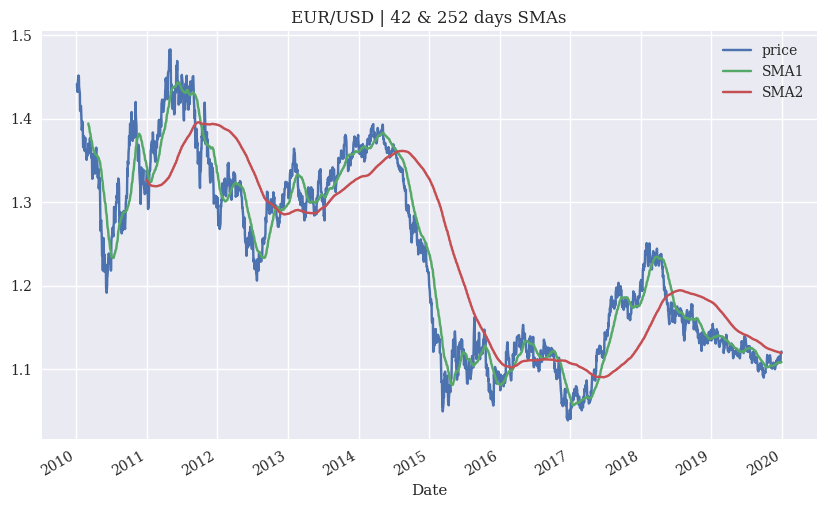

In [12]:
data.plot(
    title='EUR/USD | 42 & 252 days SMAs',
    figsize=(10,6)
)

#### __Generating Signals aka Market Positionings__

Market positionings are generated based on the *relationship between the two SMAs* according to the following rule:

1. __Go long__ whenever the shorter SMA (SMA1, 42 days) above the longer one.
2. __Go short__ whenever the longer SMA (SMA2, 252 days) above the shorter one.

*Long positions* will be indicated by 1, *short positions* will be indicated by -1.

In [13]:
# directly comparing two columns of the DataFrame object with np.where()
# the expression to be tested is data['SMA1'] > data['SMA2']
# if True position is set to 1
# if False position is set to -1
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [14]:
data

,price,SMA1,SMA2,position
Date,,,,
2010-01-04,1.4411,NaN,NaN,-1
2010-01-05,1.4368,NaN,NaN,-1
2010-01-06,1.4412,NaN,NaN,-1
2010-01-07,1.4318,NaN,NaN,-1
2010-01-08,1.4412,NaN,NaN,-1
...,...,...,...,...
2019-12-24,1.1087,1.107698,1.119630,-1
2019-12-26,1.1096,1.107740,1.119529,-1
2019-12-27,1.1175,1.107924,1.119428,-1


In [15]:
data[data.position > 0]

,price,SMA1,SMA2,position
Date,,,,
2010-12-31,1.3377,1.342579,1.326218,1
2011-01-03,1.3351,1.340945,1.325798,1
2011-01-04,1.3301,1.338940,1.325374,1
2011-01-05,1.3151,1.336448,1.324874,1
2011-01-06,1.3001,1.333995,1.324351,1
...,...,...,...,...
2018-06-07,1.1797,1.196914,1.190190,1
2018-06-08,1.1766,1.195514,1.190410,1
2018-06-11,1.1782,1.194126,1.190644,1


In [16]:
# deleting all rows of data that contain at least one NaN value
data.dropna(inplace=True) # parameter is necessary here
data

,price,SMA1,SMA2,position
Date,,,,
2010-12-31,1.3377,1.342579,1.326218,1
2011-01-03,1.3351,1.340945,1.325798,1
2011-01-04,1.3301,1.338940,1.325374,1
2011-01-05,1.3151,1.336448,1.324874,1
2011-01-06,1.3001,1.333995,1.324351,1
...,...,...,...,...
2019-12-24,1.1087,1.107698,1.119630,-1
2019-12-26,1.1096,1.107740,1.119529,-1
2019-12-27,1.1175,1.107924,1.119428,-1


#### <span style="color:green">__Interlude: numpy.where__</span>

`numpy.where(condition, [x, y, ]/)`

Parameters:
- condition
  - array_like, bool
  - Where True, yield x, otherwise yield y.

- x, y
  - array_like
  - Values from which to choose. x, y and condition need to be broadcastable to some shape.

[NumPy reference > numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

In [17]:
# examples
a = np.arange(10)
print(a)
np.where(a < 5, a, 10*a)

[0 1 2 3 4 5 6 7 8 9]


array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])

In [18]:
# multidimensional array example
a = np.array([[0, 1, 2],
              [0, 2, 4],
              [0, 3, 6]])
print(a)
np.where(a < 4, a, -1)

[[0 1 2]
 [0 2 4]
 [0 3 6]]


array([[ 0,  1,  2],
       [ 0,  2, -1],
       [ 0,  3, -1]])

#### <span style="color:green">__Interlude end__</span>


<Axes: title={'center': 'Market Positioning'}, xlabel='Date'>

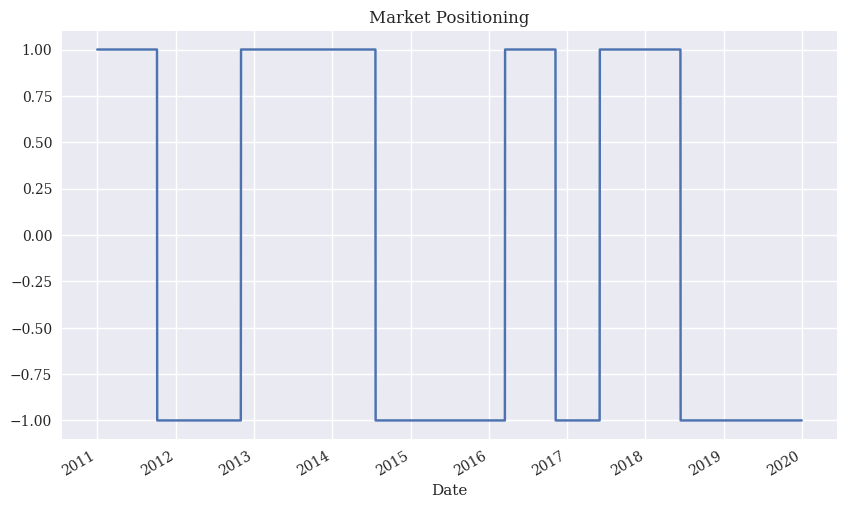

In [19]:
# now lets plot the positioning over time
data['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10,6)
)

#### __Calculating the Performance of the Strategy__

To calculate the performance of the strategy we calculate the log returns based on the original financial time series (that our EUR price column).

In [20]:
# calculating the log returns in vectorized fashion
data['returns'] = np.log(data['price'] / data['price'].shift(1))

<Axes: >

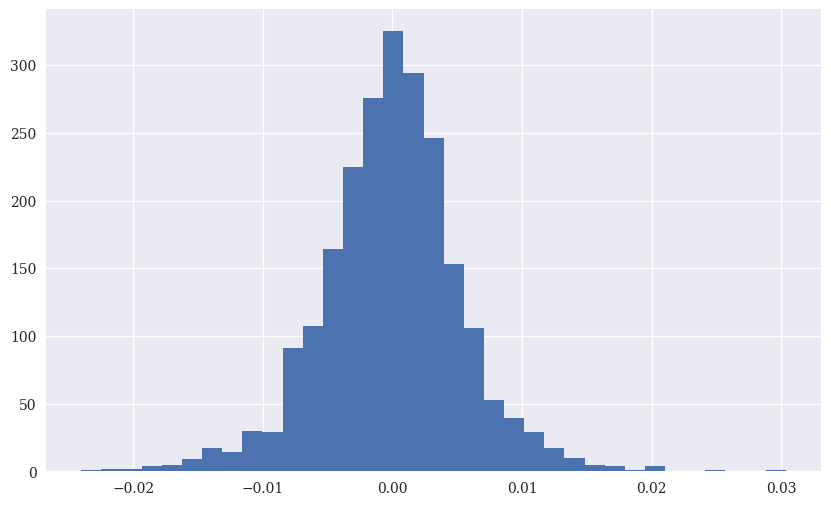

In [21]:
# plotting the log returns as a histogram
data['returns'].hist(bins=35, figsize=(10, 6))

#### __Comparing the Returns__

In [22]:
# (1) deriving the log returns of the strategy given the positionings and the market returns
data['strategy'] = data['position'].shift(1) * data['returns']

In [23]:
# (2) summing up the single log return values for the stock and the strategy (illustratory purpose)
data[['returns', 'strategy']].sum() 

returns    -0.176731
strategy    0.253121
dtype: float64

In [24]:
# applying the expotential function to the sum of the log returns to calculate the gross performance
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.838006
strategy    1.288039
dtype: float64

The results show that the strategy performs better than the passive benchmark investment.

<Axes: xlabel='Date'>

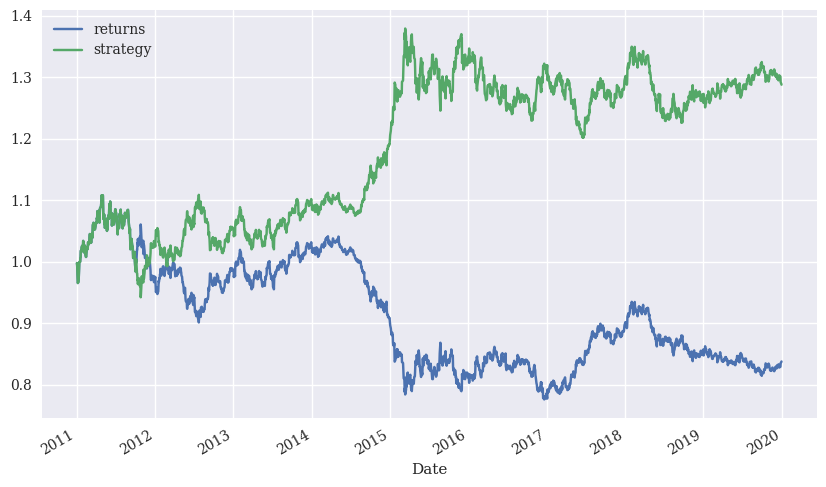

In [25]:
# showing the data graphically
# here we're calculating the cumulative sum over time with cumsum
# then the cumulative returns by applying the espotential fubction np.exp()
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

#### __Calculating Average, Annualized Risk-Return Statistics__

Calculating risk-return statistics for for the stock and the strategy:

In [29]:
# calculating the annualized mean return in log and regular space
data[['returns', 'strategy']].mean() * 252 # regular space

returns    -0.019671
strategy    0.028174
dtype: float64

In [30]:
np.exp(data[['returns', 'strategy']].mean() * 252) - 1 # log space

returns    -0.019479
strategy    0.028575
dtype: float64

In [32]:
# calculating the annualized standard deviation in log and regular space
data[['returns', 'strategy']].std() * 252 ** 0.5 # regular space

returns     0.085414
strategy    0.085405
dtype: float64

In [35]:
(data[['returns', 'strategy']].apply(np.exp) - 1).std() * 252 ** 0.5 # log space

returns     0.085405
strategy    0.085373
dtype: float64

#### __Calculating Maximum Drawdown and Longest Drawdown Period__

Two more statistics that are of interest in the context of trading strategy performances. 

Helper statistic used here: ***cumulative maximum gross performance***. It's calculated by the cummax() method applied to the gross performance of the strategy.

In [37]:
# adding a new column cumret with the gross performance over time
data['cumret'] = data['strategy'].cumsum().apply(np.exp)

In [38]:
# adding another column cummax with the gross performance over time
data['cummax'] = data['cumret'].cummax()

In [39]:
data

,price,SMA1,SMA2,position,returns,strategy,cumret,cummax
Date,,,,,,,,
2010-12-31,1.3377,1.342579,1.326218,1,NaN,NaN,NaN,NaN
2011-01-03,1.3351,1.340945,1.325798,1,-0.001946,-0.001946,0.998056,0.998056
2011-01-04,1.3301,1.338940,1.325374,1,-0.003752,-0.003752,0.994319,0.998056
2011-01-05,1.3151,1.336448,1.324874,1,-0.011341,-0.011341,0.983105,0.998056
2011-01-06,1.3001,1.333995,1.324351,1,-0.011472,-0.011472,0.971892,0.998056
...,...,...,...,...,...,...,...,...
2019-12-24,1.1087,1.107698,1.119630,-1,0.000090,-0.000090,1.302328,1.379350
2019-12-26,1.1096,1.107740,1.119529,-1,0.000811,-0.000811,1.301272,1.379350
2019-12-27,1.1175,1.107924,1.119428,-1,0.007094,-0.007094,1.292073,1.379350


<Axes: xlabel='Date'>

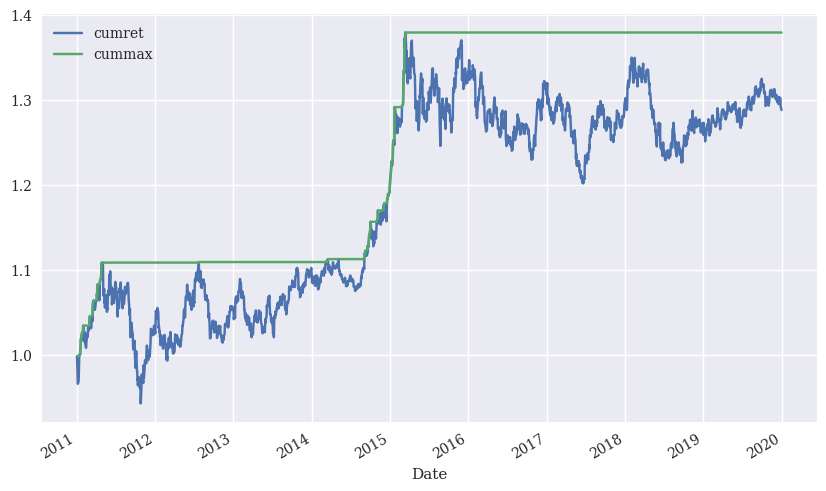

In [42]:
# plotting the two new columns of our dataframe
# in the plot we see the gross performance and the cumulative maximum performance 
# of the SMA-strategy
data[['cumret', 'cummax']].dropna().plot(figsize=(10, 6))

In [45]:
# now calculating the maximum drawdown
# by calculating the element-wise difference between the two columns
drawdown = data['cummax'] - data['cumret']
drawdown

Date
2010-12-31         NaN
2011-01-03    0.000000
2011-01-04    0.003738
2011-01-05    0.014951
2011-01-06    0.026164
                ...   
2019-12-24    0.077022
2019-12-26    0.078078
2019-12-27    0.087278
2019-12-30    0.089816
2019-12-31    0.091312
Length: 2265, dtype: float64

In [44]:
# picking out the maximum value from all diff
drawdown.max()

np.float64(0.17779367070195895)